<a href="https://colab.research.google.com/github/justingardner/tutorials/blob/master/drift_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Learning goals for the Drift Diffusion notebook. After working through this notebook you will be able to...
  * 
  

In [1]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm as progressBar

#Drift Diffusion model
[Signal Detection Theory](https://colab.research.google.com/drive/1GoaNzglcqh_Xexb9t1AJRMv95DcEHGO4#scrollTo=rwGdhE1iB_lK) can be used to get bias-free measures of subject's sensitivity, predict performance on a two alternative forced choice and has been quite useful both in psychophysics and in cognitive neuroscience where it is often used to link physiology to behavior. But, one thing it completely sweeps under the carpet is time. There is no notion of how the decision process evolves over time and so therefore it has nothing to say about reaction times. So, diffusion models.

There are many variations of diffusion models, but the basic flavor is to think of a decision variable which accumulates evidence for a choice (generically, let's call that “A”) against another choice (“B”). In the Newsome et al., experiments these would be a choice for, say, leftwards vs rightwards motion. The decision variable gets momentary evidence that is corrupted by noise (can be anything, but typically gaussian) which is integrated across time. This causes the decision variable to move randomly (brownian motion) until it hits (gets absorbed by) one of the decision criterion (bounds). Whichever bound it hits first is the decision that wins. When it hits gives you the reaction time. You should have the following picture in your head of a single trial:

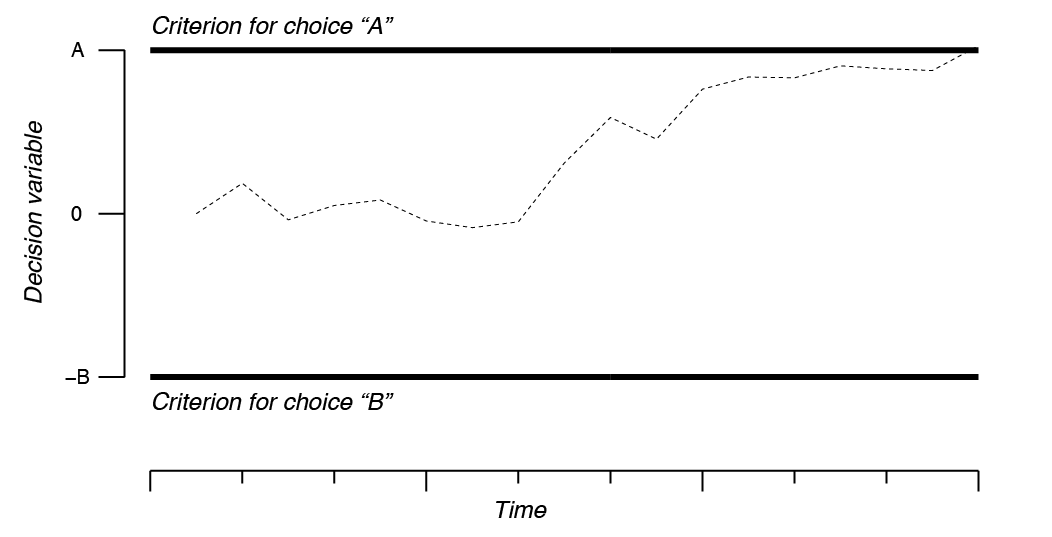

The evolution of the decision variable is literally governed by integrating random draws from a gaussian distribution whose mean governs how much evidence is acquired in each time interval and whose standard deviation is associated with how noise that evidence is. So, if you have strong evidence for choice “A”, then you would have a large positive mean. For example, if a neuron in MT fires a lot in its preferred direction, then it will contribute a large mean and the trial to trial variability will correspond to the standard deviation of the evidence. Sometimes, due to the randomness of each sample from the evidence distribution, the decision variable may take a random walk to the other boundary and a wrong decision will be made. Note, that we are, for the purpose of this tutorial, always simulating a decision process in which the correct decision is “A” (upper bound), since we are adding a positive mean to evidence.

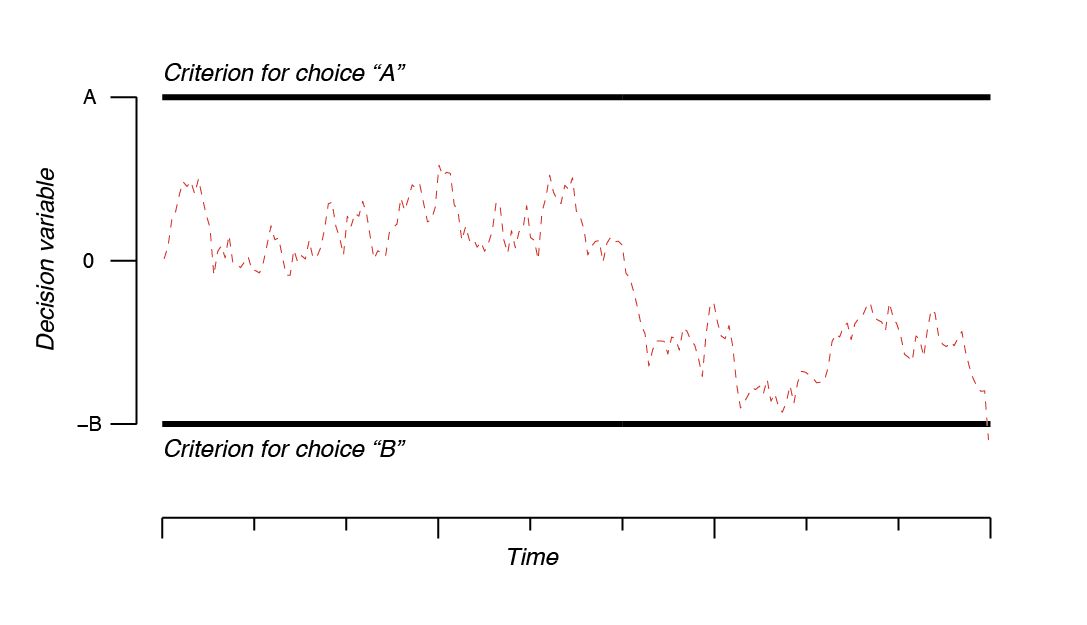

Across many trials then, having a small amount of moment-by-moment evidence (mean of the gaussian variable) relative to variability (standard deviation of the gaussian variable) accumulation will more often go to the correct bound then the incorrect bound. The time it takes to get to each bound (RT) forms a distribution and you can see that the distributions have a bit of a skew to them.

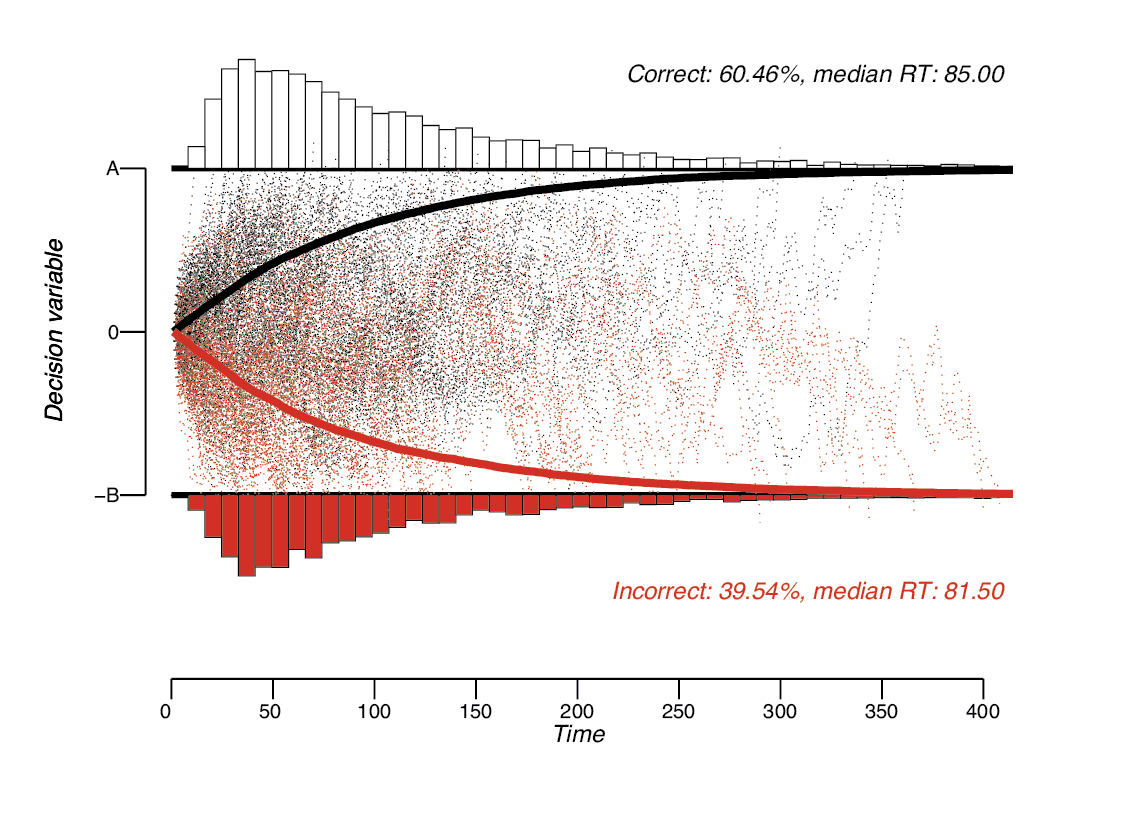

Ok. Get the basic idea? Let's try it out ourselves.

#Simulate a trial
So, the idea is to have a decision variable that over time integrates information from a random gaussian process with some mean and standard deviation. Let's start by simulating that (arbitrarily) for a process with mean = 0.1 and standard deviation = 1. Let's have the decision variable, d, start at 0. We will stop the process when it hits either the top bound, A, or the bottom bound -B. For this case, we will just have those bounds equidistant from the starting point. So A=B, and we'll just stop the process when the absolute value of d gets bigger than A. Let's make A for this simulation 10. Got it?

In [6]:
d = np.zeros(1);
A = 10;
# check the last value of d (we use matlab's end keyword 
# to get the last value in the d array - when we start this
# will just be the first value, but on each iteration of the
# loop this will increment)
while abs(d[-1]) < A:
  # put a new value at the end of the array for d which is
  # the last value of d plus a pull from the random distribution
  d = np.append(d,d[-1] + np.random.normal(loc=0.1,size=1))


Now, go ahead and plot it.

Text(0, 0.5, 'Decision variable')

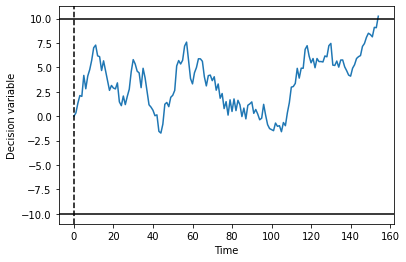

In [30]:
#plot decision variable evolution over time
plt.plot(d)
# display upper and lower bounds
plt.axhline(y=A, color='k', linestyle='-')
plt.axhline(y=-A, color='k', linestyle='-')
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Decision variable')

#Simulate multiple trials
Ok, good so far? Let's try to run that process for multiple trials (say n=100) and plot each trial as we go along. We should also keep track of what decision was made (i.e. which bound was chosen) and when that decision was made. That way at the end we can look at the predicted percent correct and the reaction time distribution - these are the basic predictions of the model. So, go ahead and try to modify the code from above to do that.

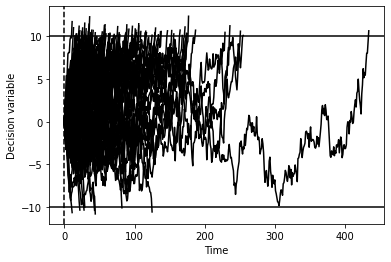

In [117]:
def simulateDriftDiffusion(A,nTrials,driftRate):

  #initialize some variables
  nCorrect = 0;
  nError = 0;
  correctRT = [];
  errorRT = [];
  dCorrect = [];
  dIncorrect = [];

  # loop over trials
  for iTrial in range(0,nTrials):
    # start decision variable at 0
    d = np.zeros(1);
    # simulate each trial
    while abs(d[-1]) < A:
      # put a new value at the end of the array for d the last value
      # of d plus a pull from the random distribution
      d = np.append(d,d[-1] + np.random.normal(loc=driftRate,size=1))

    # plot the trial
    plt.plot(d,color='k');
    # if it was correct
    if d[-1]>A:
      # then keep score
      nCorrect += 1
      correctRT = np.append(correctRT, d.size);
      # Just putting in here a variable that stores all the decision trajectories
      # computed. IT will come in use towards the end of the tutorial
      # when we compute average trajectories
      dCorrect.append(d)
    else:
      nError += 1
      errorRT = np.append(errorRT, d.size);
      dIncorrect.append(d)


  # compute percentage correct and incorrect
  pCorrect = nCorrect/nTrials
  pError = nError/nTrials
  
  # display upper and lower bounds
  plt.axhline(y=A, color='k', linestyle='-')
  plt.axhline(y=-A, color='k', linestyle='-')
  plt.axvline(x=0, color='k', linestyle='--')
  plt.xlabel('Time')
  plt.ylabel('Decision variable')

  # return values
  return pCorrect, pError, correctRT, errorRT, dCorrect, dIncorrect

# and run
nTrials = 100
pCorrect, pError, correctRT, errorRT, dCorrect, dIncorrect = simulateDriftDiffusion(10,nTrials,0.1);

Ok. So, let's see what we got. Display the percentage of correct trials vs the percentage of incorrect trials (what do you expect these to be like?)

In [114]:
print('Correct: %0.1f%% Error: %0.1f%%'%(100*pCorrect,100*pError))

Correct: 89.0% Error: 11.0%


And, let's look at the reaction time distribution (this might be more meaningful for the correct trials in which you have enough trials to be able to see what is going on.

Text(0, 0.5, 'n trials')

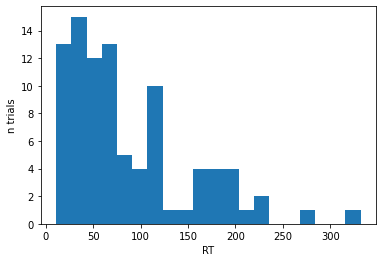

In [73]:
plt.hist(correctRT,20);
plt.xlabel('RT')
plt.ylabel('n trials')

What does the distribution look like? Is it gaussian? Is it skewed? Why does it have the shape that it does?

If you have that all working, then try the same simulation, but don't give any sensory evidence. Decisions are just based on chance fluctuations. You should expect percent correct to equal percent errors. Try it.

Correct: 49.1% Error: 50.9%


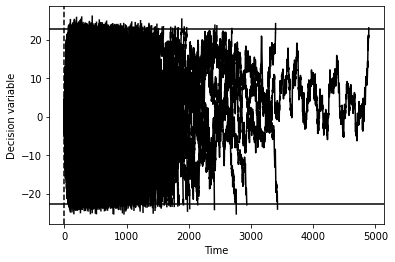

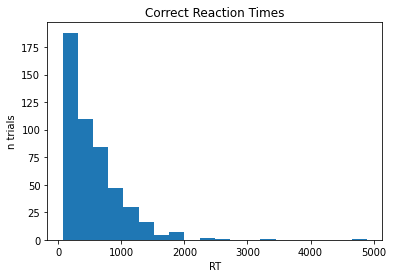

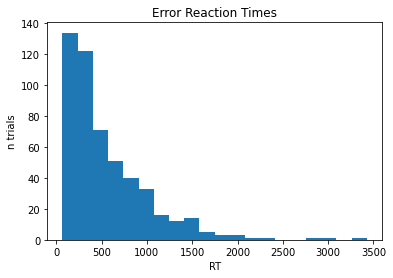

In [118]:
nTrials = 1000
pCorrect, pError, correctRT, errorRT, dCorrect, dIncorrect = simulateDriftDiffusion(A,nTrials,0);
# display what we got
print('Correct: %0.1f%% Error: %0.1f%%'%(100*pCorrect,100*pError))
plt.figure()
plt.hist(correctRT,20)
plt.xlabel('RT')
plt.ylabel('n trials')
plt.title('Correct Reaction Times')
plt.figure()
plt.hist(errorRT,20)
plt.xlabel('RT')
plt.ylabel('n trials')
plt.title('Error Reaction Times');

The thing to note about this, is that even thought the gaussian generating process had 0 mean - you still ended up on each trial meandering to one of the bounds. Random walks don't just jitter around the starting place and never go anywhere - by integration of random values they end up, by chance, going somewhere.

Try playing around with the model in different ways - what does changing the height of the bounds do? Or changing the mean? Or, the standard deviation. What about using a different distribution, not gaussian (why might you want to do that?). What about the starting point of the process?

Ok, so you should now have a rough idea of how changing different parameters of the model can affect the accuracy and reaction times. So, er, Pop quiz, what parameters can you change to affect the accuracy and reaction time?


#@Answer
The mean of the random process will cause you to accumulate larger increments of evidence for the correct decision. It will cause you to more often reach the correct upper bound “A” and will make you do that faster. You could also change the standard deviation of the gaussian process. If it had 0 standard deviation, then there would be no noise at all and you would always go predictably in a straight line up to the bound. You could also make the bounds farther away from the starting point. This will make the process have to traverse farther to get to the decision, making it less likely that you will get false alarms at the other boundary. But, this comes at a cost - it will make the decisions take a longer time to get to the bound. This is your classic speed-accuracy trade-off. If you haven't tried to play with these ideas yet with the simulation, then do so now!

#Fit behavioral data
Ok, so that's all great, but how do you fit this beast to behavioral data? Well, one answer is to do just what you have been doing - simulate many variations of the parameters until you get something that matches by some fit criteria (usually maximizes the likelihood of your data). A non-linear search algorithm can adjust the parameters for you to search the space of parameters more efficiently and you just let it go at it and come back some time later to see what it gets. While this may seem inefficient, there are times when you have to do this. In particular, if you make the model more complicated (various versions have been proposed in which you add randomness not just do the moment to moment evidence, but also to the starting point for instance) or if you want to fit the whole shape of your reaction time distributions you may wish to do a fit like this. If you go in that direction, take a look at[ Roger Ratcliff's webpage](https://u.osu.edu/ratcliffmckoon/the-diffusion-model/) which has links to various packages for fitting drift diffusion models. Also, make sure to read some of the papers that are listed on his website. There are a number of important considerations you should be aware of when fitting data - including cases in which fits might not produce good model parameter estimates and other cases in which multiple parameter settings can achieve the same effect (consider yourself forewarned!).

But, if you just want to fit your percent correct and mean reaction times. There are closed-form solutions that give you equations for how to do this.

$P_{correct} = \frac{1}{1+e^{-2{\mu}A}}$

This first equations tells you what to expect for the probability correct, given the bounds (assuming symmetrical bounds) A and the mean of the process μ. Where does this come from? Well it comes from a mathematical derivation which is a bit complicated (see: [here](https://www.shadlenlab.columbia.edu/publications/publications/mike/okinawa_chapter2006.pdf) for a helpful primer). But, you can think of it as the solution to the following problem. Given bounds A and a gaussian process with some mean and standard deviation, what is the probability that the process will end up at the top bound instead of the bottom bound. The solution is the above equation.

Let's take a look at the form of the equation and see if it makes sense. How does it change as you make μ bigger and bigger? You know what to expect, right? So, punch the equation into matlab and see what it does for different values.

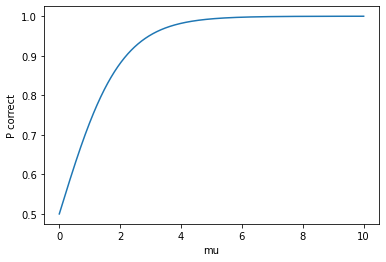

In [84]:
A = 1
mu = np.linspace(0,10,1000)
plt.plot(mu,1./(1+np.exp(-mu*A)))
plt.xlabel('mu');
plt.ylabel('P correct');

But, wait a second. What happened to the standard deviation? You know from above that it matters. But, it's not in the equation, why? Well, it actually should be. The full equation should read:

$P_{correct} = \frac{1}{1+e^{\frac{-2{\mu}A}{\sigma^{2}}}}$

Trouble is, changing A and changing sigma amount to the same thing, just in opposite directions. They are both unobserved variables, so you cannot estimate both of them. So, you just estimate one and say that you estimate the ratio of the two. You might say the same thing about μ and A, but take a look first at the solution for when on average you hit the bound:

$RT_{mean} = \frac{A}{\mu}tanh(\mu A)$

Ok, what shape does that give you? Well, plot it as a function of μ just like you did for the percent correct equation and see what it looks like.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


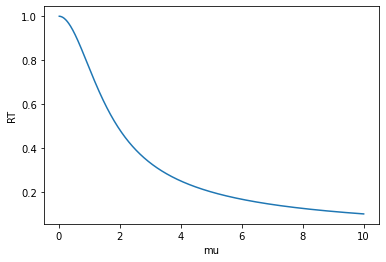

In [89]:
A = 1;
mu = np.linspace(0,10,1000)
plt.plot(mu,(A/mu)*np.tanh(mu*A))
plt.xlabel('mu');
plt.ylabel('RT');

What do you get for that? Does the shape of it make sense? What happens as mu gets larger and larger?

One thing to note here. This is the **average** reaction time. Remember that the distributions from above look skewed? This does not tell you anything about the skew of the distribution, just the central tendency. The model actually predicts a particular skewed shape of the reaction time distribution and that may be important. It is not fit, when you use the above equation.

Another thing. What are the units here? We want them to be in milliseconds, for example. If the monkey takes, say, 800ms to make the decision, then this equation needs to be fit such that you get a value of 800. Right? So, change A and see what happens. Can you get a value of 800 out of the equation?

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


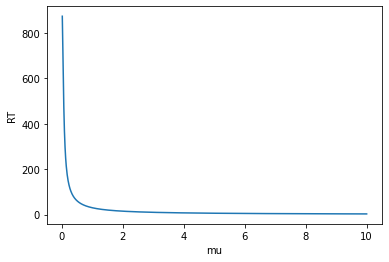

In [93]:
A = 30;
mu = np.linspace(0,10,1000)
plt.plot(mu,(A/mu)*np.tanh(mu*A));
plt.xlabel('mu');
plt.ylabel('RT');

You see that you get some value of mu that will give you 800 ms? You can now imagine playing around with values of mu and A to fit your reaction time data. But, what's the longest reaction time you should expect for some A and mu? Is it actually plotted on the graph?

No. The computation A/mu results in a NaN when mu is 0, so it is not showing up on the graph

But, we may want to know what to expect for a reaction time when mu is 0 and there is no sensory evidence (this is a very important case, right? Remember how choice probabilities were calculated in the Newsome experiment?) So, to do that you need to take limits:

$RT_{mean} = \lim_{\mu \to 0}\frac{A}{\mu}tanh(\mu A) = A^{2}$

Ok. Good, so now we have an expression for the reaction times as a function of all possible μ

But, hey, wait a second. Notice something else here? What value is the shortest reaction time that the model predicts?



In the limit, 0. If you make mu really large (lots of evidence), the equation predicts that you could reach the bound ever faster, in no time at all!

But, this isn't really true for behavioral data. There must be some inherent delays associated with the time visual input is transduced and motor delays, at least, right? So, to fix that people put in, a, well, fudge factor - an independent “non decision” time. So, you get another free parameter to fit:

$RT_{mean} = \frac{A}{\mu}tanh(\mu A) + \tau_{non decision}$

From the above, we now know that to fit behavioral data, we have two free parameters μ and A. How do Shadlen et al., fit their behavioral data? Well they know that as you increase motion coherence, that neurons in MT increase their response approximately linearly [Britten KH, Shadlen MN, Newsome WT, Movshon JA (1993) Vis Neurosci 10:1157–1169](https://www.jneurosci.org/content/12/12/4745). Here are a few examples of MT neurons responding increasing (or decreasing) as motion coherence is increased in their preferred (or anti-preferred) direction:

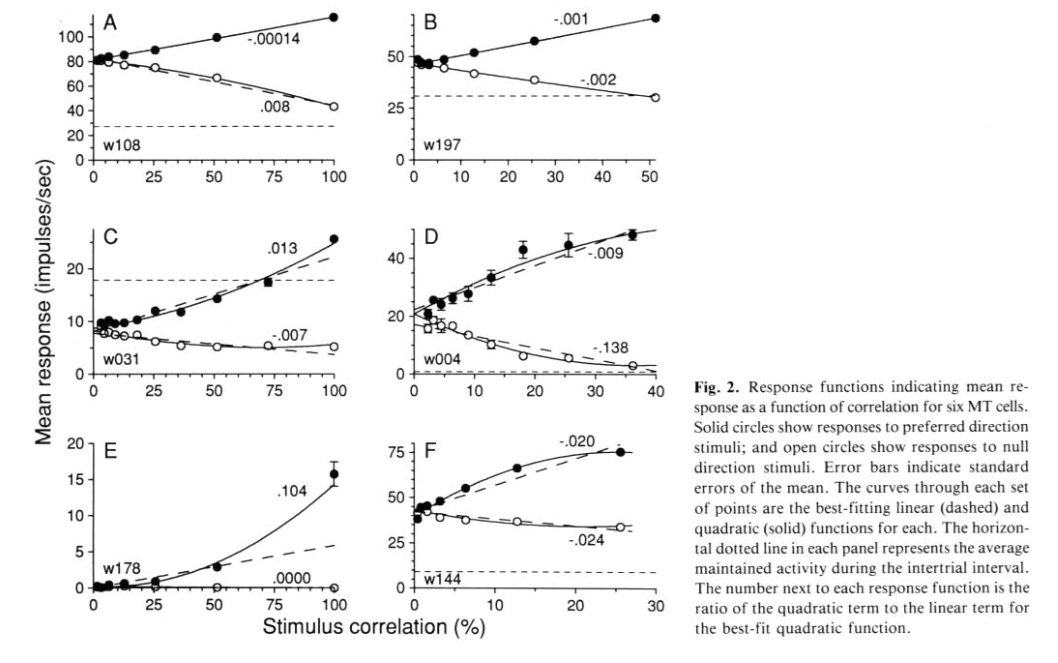

So, they assume that increasing coherence (C) increases the μ of the evidence process linearly. You need a scaling parameter, k, to get the parameters right. So, the equations they use, are simply the ones from above where μ has been replaced with kC (remember that C is known to them - it is the motion coherence that they used).

Pop quiz. What would you do if you were trying to model decisions and you changed image contrast, not coherence?

So, let's take some values from fits to monkey behavioral data from [Huk & Shadlen, 2005](https://www.jneurosci.org/content/25/45/10420), Figure 3. Where k = 0.426, A = 22.811 and tau (non decision time) = 417ms. Coherence of motion is varied from 0 to .50. What do we get?

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


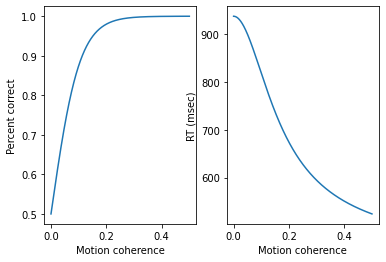

In [95]:
# parameters
k = 0.426;
A = 22.811;
tau = 417;
C = np.linspace(0,0.5,1000)

# percent correct
p = 1/(1+np.exp(-2*k*C*A));
rt = (A/(k*C))*np.tanh(k*C*A) + tau;

# get the reaction time for when coherence = 0
rt[0] = A**2 + tau;

# now plot as a function of coherence
plt.subplot(1,2,1);
plt.plot(C,p);
plt.xlabel('Motion coherence');
plt.ylabel('Percent correct');
plt.subplot(1,2,2);
plt.plot(C,rt);
plt.xlabel('Motion coherence');
plt.ylabel('RT (msec)');

It is convenient to plot on the same graph, the performance for the opposite motion direction as well (typically because we are studying a neuron and we want to know about choices made in the preferred direction vs the anti-preferred direction). When we do this, by convention, we call negative motion coherence more evidence for motion in the anti-preferred direction and we plot as a function of choices to the preferred direction. Try and plot the full curve this way.

Text(0, 0.5, 'reaction time (ms)')

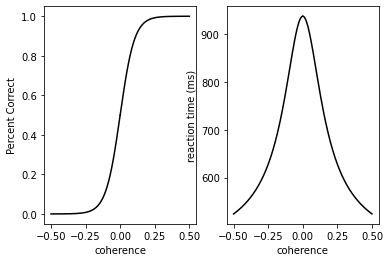

In [102]:
plt.subplot(1,2,1);
plt.plot(-C,1-p,color='k');
plt.plot(C,p,color='k');
plt.xlabel('coherence')
plt.ylabel('Percent Correct')
plt.subplot(1,2,2);
plt.plot(-C,rt,color='k');
plt.plot(C,rt,color='k');
plt.xlabel('coherence')
plt.ylabel('reaction time (ms)')

So, that is the solution using the equations. Does it actually match our simulation? Well, try it out. Set the parameters from above, for a low coherence, say 0.05, and see if you get the expectation from the equations. BTW, what is the expectation?

Plug the values into the equation for p and RT from above. You should get (rounding the value a bit): 0.73 for probability correct and for RT, you should get: 899.9

Correct: 74.2% Error: 25.8%
Correct reaction time: 941.5ms


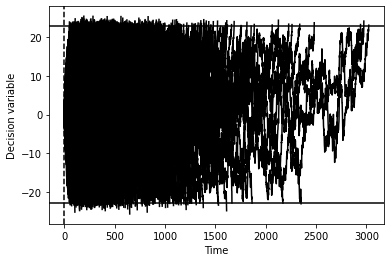

In [119]:
# simulation parameters
nTrials = 1000
A = 22.811
k = 0.426
C = 0.05
tau = 418

pCorrect, pError, correctRT, errorRT, dCorrect, dIncorrect = simulateDriftDiffusion(A,nTrials,k*C);

# calculate the mean of the reaction times
errorRT = np.mean(correctRT)
# add in the non-decision time tau
errorRT += tau

# display what we got
print('Correct: %0.1f%% Error: %0.1f%%'%(100*pCorrect,100*pError))
print('Correct reaction time: %0.1fms'%(errorRT))


What does this imply about the underlying decision process? Well, let's see what on average the process looks like for. To do this, simulate the decision process from above, but this time keep a copy of each actual decision process (just for correct trials), so that we can average and look at it afterwords. That means instead of one array d, we should make a matrix d with rows equal to trials of the decision process and columns equal to time points. Note this is a bit tricky, since each decision process can last a different amount of time. In the end, we will put the value of the bound into each decision process for the time that it terminates to the end of the simulation time (since the assumption is that the process is just absorbed into the bound). Let's do that for two different values of contrast and see what we get.

Text(0, 0.5, 'Decision variable')

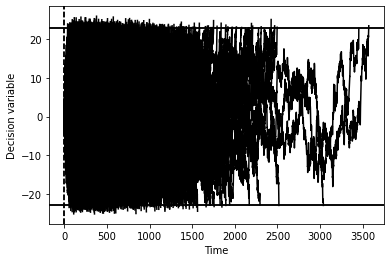

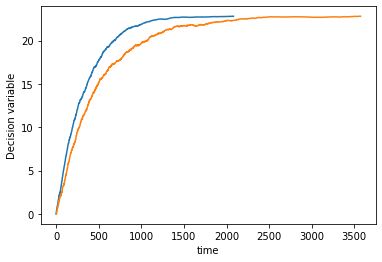

In [173]:
# set up the simulation variables
k = 0.426;
A = 22.811;
tau = 417;
C = 0.1;
n = 10;

#simulate decision process for contrast of 0.05
pCorrect, pError, correctRT, errorRT, dCorrect, dIncorrect = simulateDriftDiffusion(A,nTrials,k*C);

# compute mean response on correct trials
# first get maximum length of decision process
maxLength = max(dTrial.size for dTrial in dCorrect)
# init variables
dAllCorrect = []
# for every trial in dCorrect
for dTrial in dCorrect:
  # add on some response at the boundary, to fill out trial
  dTrial = np.append(dTrial,np.ones(maxLength - dTrial.size)*A)
  # and put that in dAllCorrect
  dAllCorrect.append(dTrial);

# calculate mean response for these trials
meanResponse1 = np.matrix.mean(np.matrix(dAllCorrect).T,axis=1)

# now do the same for a lower contrast
C = 0.005

# repeate code from above to compute mean response for this lower contrast
pCorrect, pError, correctRT, errorRT, dCorrect, dIncorrect = simulateDriftDiffusion(A,nTrials,k*C);
maxLength = max(dTrial.size for dTrial in dCorrect)
dAllCorrect = []
for dTrial in dCorrect:
  dTrial = np.append(dTrial,np.ones(maxLength - dTrial.size)*A)
  dAllCorrect.append(dTrial);
meanResponse2 = np.matrix.mean(np.matrix(dAllCorrect).T,axis=1)

# plot the two response
plt.figure()
plt.plot(meanResponse1)
plt.plot(meanResponse2)
plt.xlabel('time')
plt.ylabel('Decision variable')

If you do that across the coherences used in [Roitman & Shadlen, 2002](https://pubmed.ncbi.nlm.nih.gov/12417672/), would it look like what they recorded from LIP?

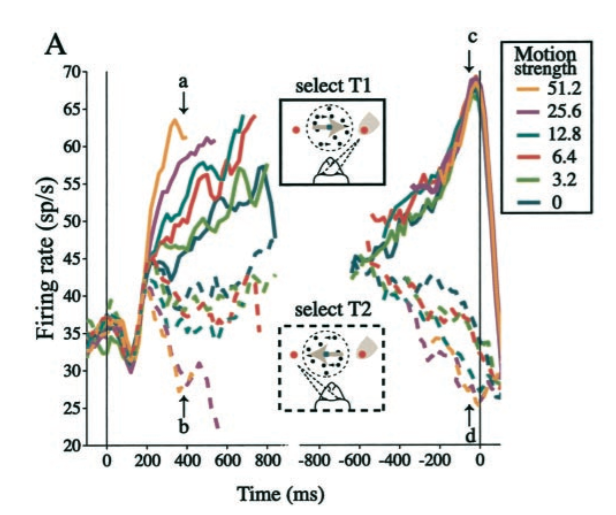